In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

In [2]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def get_cum_inf_trajectory(df):
    return np.sum(df[['cumulative_mild', 'cumulative_severe']], axis=1)

def get_cum_hosp_trajectory(df):
    return np.sum(df[['severity_3', 'severity_2']], axis=1)

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total


In [3]:
# Fall Semester Group Config

# Loading group params
base_directory = '../src/simulations_v2/params/jan4calibration/'

# ug_ga_params = load_params(base_directory + 'group_1_students_post_movein_private.yaml')[1]
# ug_other_params = load_params(base_directory + 'group_2_students_post_movein_private.yaml')[1]
# gs_params = load_params(base_directory + 'group_3_students_post_movein_private.yaml')[1]
fs_params = load_params(base_directory + 'faculty_staff_post_movein_private.yaml')[1]
#params_list = [ug_ga_params.copy(), ug_other_params.copy(), gs_params.copy(), fs_params.copy()]
# params_list = [ug_ga_params.copy(), ug_other_params.copy(), gs_params.copy()]
params_list = [fs_params.copy(), fs_params.copy()]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [4]:
# adding population size
params_list[0]['population_size'] = 10283
params_list[1]['population_size'] = 10283

x = 0.5

interaction_matrix = np.array([[10 , 0],
                              [0 , 10 * x]])

params_list[0]['exposed_infection_p'] = 0.015
params_list[1]['exposed_infection_p'] = 0.015


# Set daily outside infection p



# Set contacts per day

params_list[0]['expected_contacts_per_day'] = 10
params_list[1]['expected_contacts_per_day'] = 10 * x

params_list[0]['test_population_fraction'] = 1/7
params_list[1]['test_population_fraction'] = 0

# Making up initial ID prevalence
params_list[0]['initial_ID_prevalence'] = 0
params_list[1]['initial_ID_prevalence'] = 0

# params_list[0]['test_protocol_QFNR'] = 0.25
# params_list[1]['test_protocol_QFNR'] = 0.25
    
group_names = ['FS residential', 'FS virtual']

In [5]:
params_list[0]

{'severity_prevalence': array([0.47808584, 0.50907724, 0.00940271, 0.00343422]),
 'max_time_exposed': 7,
 'exposed_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_ID': 8,
 'ID_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_mild': 20,
 'SyID_mild_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'max_time_SyID_severe': 20,
 'SyID_severe_time_function': <function analysis_helpers.poisson_waiting_function.<locals>.<lambda>(n)>,
 'mild_symptoms_daily_self_report_p': 0,
 'cases_isolated_per_contact': 0.255,
 'cases_quarantined_per_contact': 2.5,
 'contact_trace_testing_frac': 1,
 'contact_tracing_delay': 1,
 'sample_QI_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'sample_QS_exit_function': <function analysis_helpers.binomial_exit_function.<locals>.<lambda>(n)>,
 'daily_outside_infection_p': 2.

In [8]:
from multiprocessing import Process
import pickle


def get_trajectories(transmission_p, n, T=19*7):
    
    for idx in range(2):
        params_list[idx]['exposed_infection_p'] = transmission_p
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    trajectories = list()
    
    for _ in range(n):
        sim.run_new_trajectory(T)
        group_results = []
        for group in sim.sims:
            df = group.sim_df
            group_results.append(df)
        trajectories.append(group_results)

    return trajectories

def sim_target_f(transmission_p, ntrajectories, pickle_file_loc):
    results = get_trajectories(transmission_p, ntrajectories)
    pickle.dump(results, open(pickle_file_loc, "wb"))

def run_sims_new_process(transmission_p, ntrajectories, pickle_file_loc):
    p = Process(target = sim_target_f, args = (transmission_p, ntrajectories, pickle_file_loc))
    p.start()
    return p




In [68]:
base_transmission_p = 0.015
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]

# output_dir = "jan_12_multigroup_sim_results_employees/"
# output_dir = "jan_12_multigroup_sim_results_employees_uk_winter_adjusted/"
output_dir = "jan_12_multigroup_sim_results_employees_test_sensitivity/"

ntrajectories = 30

processes = []

for transmission_p in transmission_ps_to_try:
    filename = output_dir + "transmission_p_{}.pickle".format(transmission_p)
    p = run_sims_new_process(transmission_p, ntrajectories, filename)
    processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 26 processes


In [69]:

def extract_sim_properties(fname):
    subname = fname.split('transmission_p_')[-1]
    subname = subname.split('.pickle')[0]
    return float(subname)

def load_sim_output(fname):
    with open(fname, "rb") as handle:
        sim_output = pickle.load(handle)
    return sim_output

def load_sim_outputs(sim_output_dir):
    sim_pickle_files = [sim_output_dir + '/' + file for  file in os.listdir(sim_output_dir) if '.pickle' in file]

    sim_outputs = {}
    for fname in sim_pickle_files:
        transmission_p = extract_sim_properties(fname)
        sim_output = load_sim_output(fname)
        sim_outputs[transmission_p] = sim_output

    print("Loaded {} simulation results".format(len(sim_outputs)))
    return sim_outputs

sim_outputs = load_sim_outputs('./'+output_dir)

Loaded 26 simulation results


In [ ]:
# get_cum_infections(sim_outputs[0.02][0][0])
len(sim_outputs[0.02])

In [70]:
def get_avg_infxns_by_group(sim_output):
    infxns = sim_output
    infxns_by_group = {idx:0 for idx in range(2)}
    for trajectory_data in infxns:
        for idx in range(2):
#             import pdb; pdb.set_trace()
            
            infxns_by_group[idx] += get_cum_infections(trajectory_data[idx]) / (len(infxns) * params_list[idx]['population_size'])
    return infxns_by_group


# def get_avg_hosps_by_group(sim_output):
#     infxns = sim_output[1]
#     infxns_by_group = {idx:0 for idx in range(3)}
#     for trajectory_data in infxns:
#         for idx in range(3):
#             infxns_by_group[idx] += trajectory_data[idx] / (len(infxns) * params_list[idx]['population_size'])
#     return infxns_by_group


avg_infxns_by_transmission_p = {}
# avg_hosps_by_transmission_p = {}
for t_p in sim_outputs:
    avg_infxns_by_transmission_p[t_p] = get_avg_infxns_by_group(sim_outputs[t_p])
#     avg_hosps_by_transmission_p[t_p] = get_avg_hosps_by_group(sim_outputs[t_p])

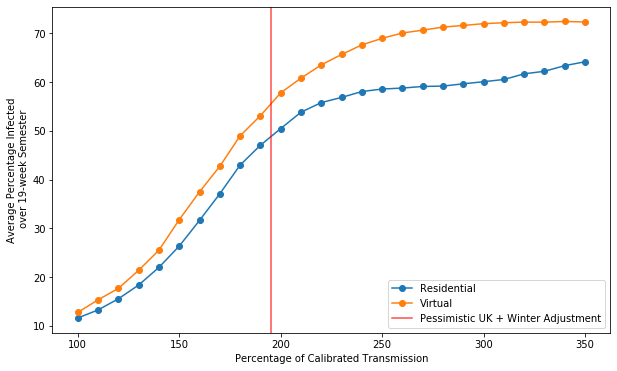

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

group_labels={0: 'Residential', 1:'Virtual'}

plt.figure(figsize=(10,6))
for groupidx in range(2):
    group_infxns = []
    for t_p in transmission_ps_to_try:
        group_infxns.append(avg_infxns_by_transmission_p[t_p][groupidx] * 100)
    plt.plot([100 * t_p / base_transmission_p for t_p in transmission_ps_to_try], 
             group_infxns, marker='o', label=group_labels[groupidx])
plt.axvline(1.56*1.25*100, label='Pessimistic UK + Winter Adjustment', color='red', alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Percentage of Calibrated Transmission')
plt.ylabel('Average Percentage Infected\n over 19-week Semester')
plt.show()

### Cases over time

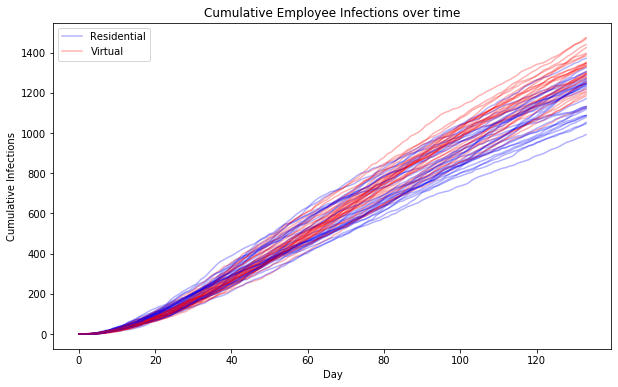

In [79]:
plt.figure(figsize=(10,6))

label = True

for sim_run in sim_outputs[base_transmission_p]:
    if label:
        get_cum_inf_trajectory(sim_run[0]).plot(color='blue', alpha=0.3, label='Residential')
        get_cum_inf_trajectory(sim_run[1]).plot(color='red', alpha=0.3, label='Virtual')
        label=False
        plt.legend(loc='best')
    else:
        get_cum_inf_trajectory(sim_run[0]).plot(color='blue', alpha=0.3)
        get_cum_inf_trajectory(sim_run[1]).plot(color='red', alpha=0.3)

plt.xlabel('Day')
plt.ylabel('Cumulative Infections')
plt.title('Cumulative Employee Infections over time')
        
plt.show()

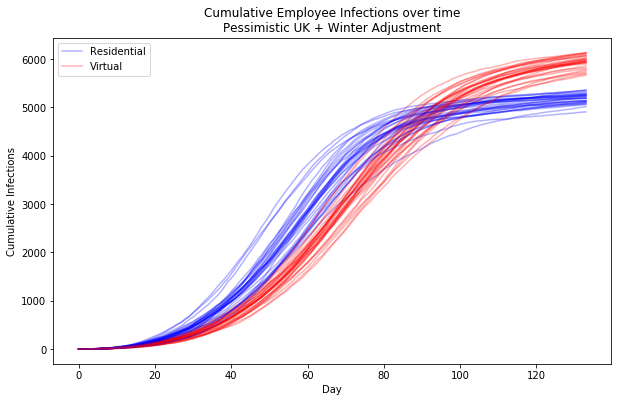

In [83]:
plt.figure(figsize=(10,6))

label = True

for sim_run in sim_outputs[0.030000000000000013]:
    if label:
        get_cum_inf_trajectory(sim_run[0]).plot(color='blue', alpha=0.3, label='Residential')
        get_cum_inf_trajectory(sim_run[1]).plot(color='red', alpha=0.3, label='Virtual')
        label=False
        plt.legend(loc='best')
    else:
        get_cum_inf_trajectory(sim_run[0]).plot(color='blue', alpha=0.3)
        get_cum_inf_trajectory(sim_run[1]).plot(color='red', alpha=0.3)

plt.xlabel('Day')
plt.ylabel('Cumulative Infections')
plt.title('Cumulative Employee Infections over time\nPessimistic UK + Winter Adjustment')
        
plt.show()

In [81]:
sim_outputs.keys()

dict_keys([0.05100000000000003, 0.05250000000000003, 0.03600000000000002, 0.04950000000000003, 0.03450000000000002, 0.04800000000000003, 0.031500000000000014, 0.043500000000000025, 0.04200000000000002, 0.021000000000000005, 0.02700000000000001, 0.024000000000000007, 0.02550000000000001, 0.04650000000000003, 0.033000000000000015, 0.03750000000000002, 0.018000000000000002, 0.03900000000000002, 0.045000000000000026, 0.022500000000000006, 0.04050000000000002, 0.015, 0.02850000000000001, 0.030000000000000013, 0.019500000000000003, 0.0165])

### Jan 14 experiment

In [84]:
# Fall Semester Group Config

# Loading group params
base_directory = '../src/simulations_v2/params/jan4calibration/'

# ug_ga_params = load_params(base_directory + 'group_1_students_post_movein_private.yaml')[1]
# ug_other_params = load_params(base_directory + 'group_2_students_post_movein_private.yaml')[1]
# gs_params = load_params(base_directory + 'group_3_students_post_movein_private.yaml')[1]
fs_params = load_params(base_directory + 'faculty_staff_post_movein_private_v2.yaml')[1]
#params_list = [ug_ga_params.copy(), ug_other_params.copy(), gs_params.copy(), fs_params.copy()]
# params_list = [ug_ga_params.copy(), ug_other_params.copy(), gs_params.copy()]
params_list = [fs_params.copy(), fs_params.copy()]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [85]:
x = 0.5

interaction_matrix = np.array([[10 , 0],
                              [0 , 10 * x]])

# Set contacts per day

params_list[0]['expected_contacts_per_day'] = 10
params_list[1]['expected_contacts_per_day'] = 10 * x

params_list[0]['test_population_fraction'] = 1/7
params_list[1]['test_population_fraction'] = 0

# Making up initial ID prevalence
params_list[0]['initial_ID_prevalence'] = 0
params_list[1]['initial_ID_prevalence'] = 0

group_names = ['FS residential', 'FS virtual']

In [86]:
from multiprocessing import Process
import pickle


def get_trajectories(transmission_p, n, T=19*7):
    
    for idx in range(2):
        params_list[idx]['exposed_infection_p'] = transmission_p
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)

    trajectories = list()
    
    for _ in range(n):
        sim.run_new_trajectory(T)
        group_results = []
        for group in sim.sims:
            df = group.sim_df
            group_results.append(df)
        trajectories.append(group_results)

    return trajectories

def sim_target_f(transmission_p, ntrajectories, pickle_file_loc):
    results = get_trajectories(transmission_p, ntrajectories)
    pickle.dump(results, open(pickle_file_loc, "wb"))

def run_sims_new_process(transmission_p, ntrajectories, pickle_file_loc):
    p = Process(target = sim_target_f, args = (transmission_p, ntrajectories, pickle_file_loc))
    p.start()
    return p


In [87]:
base_transmission_p = 0.015
transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]

# output_dir = "jan_12_multigroup_sim_results_employees/"
# output_dir = "jan_12_multigroup_sim_results_employees_uk_winter_adjusted/"
output_dir = "jan_14_multigroup_sim_results_employees/"

ntrajectories = 30

processes = []

for transmission_p in transmission_ps_to_try:
    filename = output_dir + "transmission_p_{}.pickle".format(transmission_p)
    p = run_sims_new_process(transmission_p, ntrajectories, filename)
    processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 26 processes


In [88]:
sim_outputs = load_sim_outputs('./'+output_dir)

Loaded 26 simulation results


In [89]:
def get_avg_infxns_by_group(sim_output):
    infxns = sim_output
    infxns_by_group = {idx:0 for idx in range(2)}
    for trajectory_data in infxns:
        for idx in range(2):
#             import pdb; pdb.set_trace()
            
            infxns_by_group[idx] += get_cum_infections(trajectory_data[idx]) / (len(infxns) * params_list[idx]['population_size'])
    return infxns_by_group


# def get_avg_hosps_by_group(sim_output):
#     infxns = sim_output[1]
#     infxns_by_group = {idx:0 for idx in range(3)}
#     for trajectory_data in infxns:
#         for idx in range(3):
#             infxns_by_group[idx] += trajectory_data[idx] / (len(infxns) * params_list[idx]['population_size'])
#     return infxns_by_group


avg_infxns_by_transmission_p = {}
# avg_hosps_by_transmission_p = {}
for t_p in sim_outputs:
    avg_infxns_by_transmission_p[t_p] = get_avg_infxns_by_group(sim_outputs[t_p])
#     avg_hosps_by_transmission_p[t_p] = get_avg_hosps_by_group(sim_outputs[t_p])

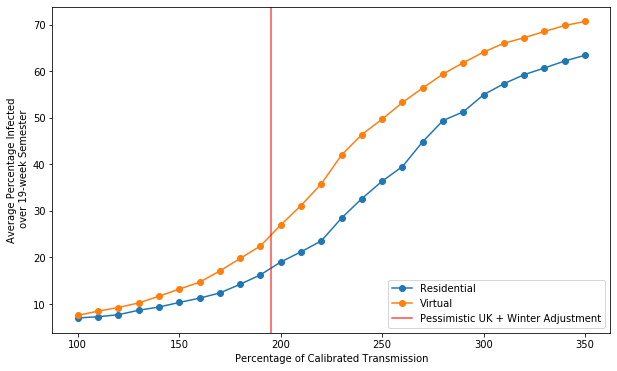

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline

group_labels={0: 'Residential', 1:'Virtual'}

plt.figure(figsize=(10,6))
for groupidx in range(2):
    group_infxns = []
    for t_p in transmission_ps_to_try:
        group_infxns.append(avg_infxns_by_transmission_p[t_p][groupidx] * 100)
    plt.plot([100 * t_p / base_transmission_p for t_p in transmission_ps_to_try], 
             group_infxns, marker='o', label=group_labels[groupidx])
plt.axvline(1.56*1.25*100, label='Pessimistic UK + Winter Adjustment', color='red', alpha=0.7)
plt.legend(loc='best')
plt.xlabel('Percentage of Calibrated Transmission')
plt.ylabel('Average Percentage Infected\n over 19-week Semester')
plt.show()

In [91]:
sim_outputs.keys()

dict_keys([0.05250000000000003, 0.04200000000000002, 0.05100000000000003, 0.04950000000000003, 0.045000000000000026, 0.04650000000000003, 0.02550000000000001, 0.043500000000000025, 0.04800000000000003, 0.031500000000000014, 0.019500000000000003, 0.030000000000000013, 0.03750000000000002, 0.03450000000000002, 0.02850000000000001, 0.0165, 0.022500000000000006, 0.024000000000000007, 0.04050000000000002, 0.03900000000000002, 0.033000000000000015, 0.02700000000000001, 0.015, 0.03600000000000002, 0.018000000000000002, 0.021000000000000005])

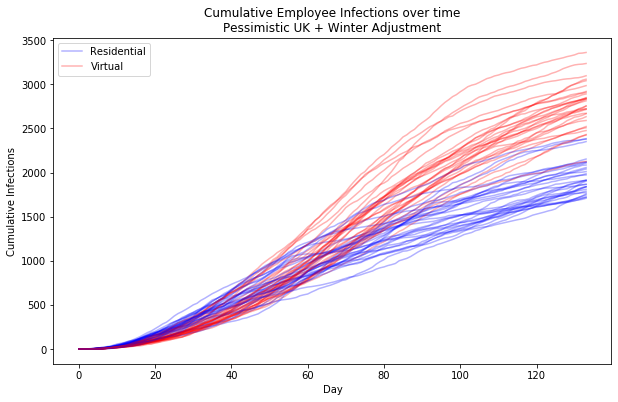

In [92]:
plt.figure(figsize=(10,6))

label = True

for sim_run in sim_outputs[0.030000000000000013]:
    if label:
        get_cum_inf_trajectory(sim_run[0]).plot(color='blue', alpha=0.3, label='Residential')
        get_cum_inf_trajectory(sim_run[1]).plot(color='red', alpha=0.3, label='Virtual')
        label=False
        plt.legend(loc='best')
    else:
        get_cum_inf_trajectory(sim_run[0]).plot(color='blue', alpha=0.3)
        get_cum_inf_trajectory(sim_run[1]).plot(color='red', alpha=0.3)

plt.xlabel('Day')
plt.ylabel('Cumulative Infections')
plt.title('Cumulative Employee Infections over time\nPessimistic UK + Winter Adjustment')
        
plt.show()

# Trajectories

In [11]:
transmission_elevation_factor = 1.56
base_transmission_p = 0.015
# transmission_ps_to_try = [base_transmission_p * x for x in np.arange(1,3.51, 0.1)]

# params_list[0]['test_population_fraction'] = 3/7

output_dir = "jan_25_spring_traj_156_staff/"
ntrajectories = 100

processes = []

filename = output_dir + "transmission_p_{}.pickle".format(transmission_elevation_factor * base_transmission_p)
p = run_sims_new_process(transmission_elevation_factor * base_transmission_p, ntrajectories, filename)
processes.append(p)
    
print("launched {} processes".format(len(processes)))
for p in processes:
    p.join()

launched 1 processes
